In [2]:
import os
import csv
import glob 
import math
import os.path
import shutil

#os.environ["MODIN_ENGINE"] = "dask"
#from distributed import Client
#client = Client()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline

In [4]:
cd "C:\\Users\\61498\\Documents\\GitHub\\JitsPredict\\data\\interim\\Tagged\\"

C:\Users\61498\Documents\GitHub\JitsPredict\data\interim\Tagged


In [5]:
img_path = "C:\\Users\\61498\\Documents\\GitHub\\JitsPredict\\data\\interim\\Tagged\\"

In [6]:
csvnames = glob.glob("*0.csv")

In [7]:
csvnames[:9]

['2017ADCCWorldChampionshipDay1_Men_+99_1stround_CaseyHellenbergvsTomDeBlass_0.csv',
 '2017ADCCWorldChampionshipDay1_Men_+99_1stround_CaseyHellenbergvsTomDeBlass_10020.csv',
 '2017ADCCWorldChampionshipDay1_Men_+99_1stround_CaseyHellenbergvsTomDeBlass_10050.csv',
 '2017ADCCWorldChampionshipDay1_Men_+99_1stround_CaseyHellenbergvsTomDeBlass_10080.csv',
 '2017ADCCWorldChampionshipDay1_Men_+99_1stround_CaseyHellenbergvsTomDeBlass_10110.csv',
 '2017ADCCWorldChampionshipDay1_Men_+99_1stround_CaseyHellenbergvsTomDeBlass_10140.csv',
 '2017ADCCWorldChampionshipDay1_Men_+99_1stround_CaseyHellenbergvsTomDeBlass_10170.csv',
 '2017ADCCWorldChampionshipDay1_Men_+99_1stround_CaseyHellenbergvsTomDeBlass_1020.csv',
 '2017ADCCWorldChampionshipDay1_Men_+99_1stround_CaseyHellenbergvsTomDeBlass_10200.csv']

In [8]:
#Creating a single dataframe from all CSV label files
df_labels = pd.DataFrame()
for csv in csvnames:
    df = pd.read_csv(csv).T
    df['csvfile'] = csv
    df_labels = df_labels.append(df.iloc[1],ignore_index=True)

In [9]:
df_labels = df_labels.iloc[197:]

In [10]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6236 entries, 197 to 6432
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   0        6236 non-null   object
 1   1        446 non-null    object
 2   2        442 non-null    object
 3   3        432 non-null    object
 4   4        432 non-null    object
 5   5        430 non-null    object
 6   6        6236 non-null   object
 7   csvfile  6236 non-null   object
dtypes: object(8)
memory usage: 389.9+ KB


In [11]:
columns = ["verify", "p1_attire", "p2_attire", "p1_box_num", "p2_box_num","position", "flag", "label_file"]

In [12]:
df_labels.columns = columns

In [13]:
df_labels.drop(df_labels[df_labels['verify']=='Redundant'].index,inplace=True)

<AxesSubplot:xlabel='verify', ylabel='count'>

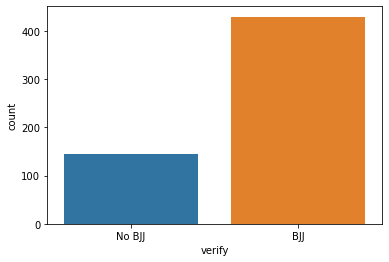

In [14]:
sns.countplot(x='verify', data=df_labels)

<AxesSubplot:xlabel='position', ylabel='count'>

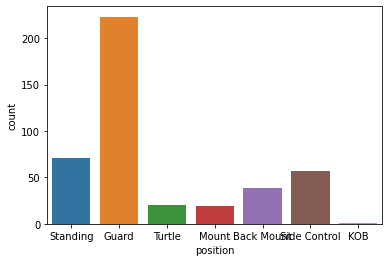

In [15]:
sns.countplot(x='position', data=df_labels)

In [16]:
def getboxes(box_num, label_file):
    dfnull = pd.DataFrame(np.zeros((1,4)),columns=['xmin','ymin','xmax','ymax'])
    try:
        df_box = pd.read_csv(label_file[:-4] + '_label_info.csv')
    except IOError:
        df_box = pd.read_csv(label_file[:-4] + '_label_info_y5.csv')
    if type(box_num) == str:
        if box_num == 'P1 Box: 0' or box_num == 'P2 Box: 0':
            return df_box.iloc[int(box_num[-1])][['xmin','ymin','xmax','ymax']]
        else:
            return df_box.iloc[int(box_num)][['xmin','ymin','xmax','ymax']]
    elif math.isnan(box_num):
        return dfnull
    elif box_num > len(df_box):
        return dfnull
    

In [17]:
df_labels[['p1_box_vals']] = df_labels.apply(lambda x: getboxes(x['p1_box_num'],x['label_file']),axis=1)
df_labels[['p2_box_vals']] = df_labels.apply(lambda x: getboxes(x['p2_box_num'],x['label_file']),axis=1)

In [18]:
#Cleaning up the boxnumbers as some values are strings and NaN's
def clean_boxnum(box_num):
    if type(box_num) == str:
        if box_num == 'P1 Box: 0' or box_num == 'P2 Box: 0':
            return int(box_num[-1])
        else:
            return int(box_num)
    elif math.isnan(box_num):
        return -1
    

In [19]:
df_labels['p1_box_cnum'] = df_labels.apply(lambda x: clean_boxnum(x['p1_box_num']),axis=1)
df_labels['p2_box_cnum'] = df_labels.apply(lambda x: clean_boxnum(x['p2_box_num']),axis=1)

C:\Users\61498\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='p1_box_cnum'>

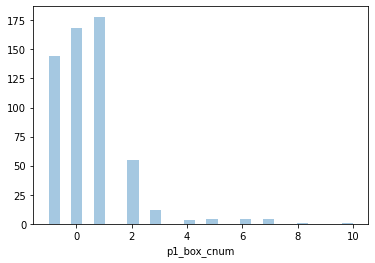

In [20]:
sns.distplot(df_labels['p1_box_cnum'], kde=False)

In [21]:
#splitting the dataframe values into individual column values for easier computations
df_labels['p1_box_xmin'] = df_labels.apply(lambda x: x['p1_box_vals']['xmin'],axis=1)
df_labels['p2_box_xmin'] = df_labels.apply(lambda x: x['p2_box_vals']['xmin'],axis=1)
df_labels['p1_box_ymin'] = df_labels.apply(lambda x: x['p1_box_vals']['ymin'],axis=1)
df_labels['p2_box_ymin'] = df_labels.apply(lambda x: x['p2_box_vals']['ymin'],axis=1)
df_labels['p1_box_xmax'] = df_labels.apply(lambda x: x['p1_box_vals']['xmax'],axis=1)
df_labels['p2_box_xmax'] = df_labels.apply(lambda x: x['p2_box_vals']['xmax'],axis=1)
df_labels['p1_box_ymax'] = df_labels.apply(lambda x: x['p1_box_vals']['ymax'],axis=1)
df_labels['p2_box_ymax'] = df_labels.apply(lambda x: x['p2_box_vals']['ymax'],axis=1)

In [22]:
#Creating a superset box for the matches to include both players if 2 boxes input
df_labels['com_box_xmin'] = df_labels.apply(lambda x: min(x['p1_box_xmin'],x['p2_box_xmin']),axis=1)
df_labels['com_box_ymin'] = df_labels.apply(lambda x: min(x['p1_box_ymin'],x['p2_box_ymin']),axis=1)
df_labels['com_box_xmax'] = df_labels.apply(lambda x: max(x['p1_box_xmax'],x['p2_box_xmax']),axis=1)
df_labels['com_box_ymax'] = df_labels.apply(lambda x: max(x['p1_box_ymax'],x['p2_box_ymax']),axis=1)

In [23]:
import cv2 as cv
from matplotlib import pyplot as plt

In [24]:
def imgprop(label_file):
    img_name = label_file[:-4] + ".jpg"
    impath = os.path.join(img_path, img_name)
    img = cv.imread(impath)
    return img

In [25]:
df_labels[['img']] = df_labels.apply(lambda x: imgprop(x['label_file']),axis=1)

In [26]:
df_labels['img_prop']= df_labels.apply(lambda x: x['img'].shape,axis=1)

In [27]:
df_labels['img_prop'].head()

197    (720, 1280, 3)
198    (720, 1280, 3)
199    (720, 1280, 3)
200    (720, 1280, 3)
201    (720, 1280, 3)
Name: img_prop, dtype: object

In [28]:
from IPython.display import Image
import cv2 as cv

In [70]:
df_labels[df_labels['label_file'] == '2017ADCCWorldChampionshipDay1_Men_-66_1stround_KubaWitkowskivsBaretYoshida_10410.csv']

,index,verify,p1_attire,p2_attire,p1_box_num,p2_box_num,position,flag,label_file,p1_box_vals,...,com_box_xmax,com_box_ymax,img_prop,yolo_x,yolo_y,b_center_x,b_center_y,b_width,b_height,class id
344,4517,BJJ,P1:No Gi Black,P2:No Gi Black,P1 Box: 0,P2 Box: 0,Guard,0.0,2017ADCCWorldChampionshipDay1_Men_-66_1stround...,xmin 292 ymin 332 xmax 1027 ymax ...,...,1027.0,635.0,"(720, 1280, 3)","(0.515234375, 0.287109375)","(0.6715277777777777, 0.21041666666666667)",0.515234,0.671528,0.287109,0.210417,0


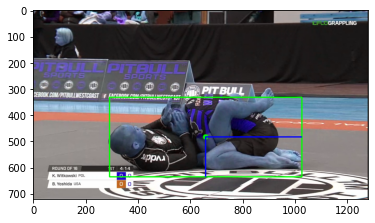

In [76]:
i = 344
img = cv.imread(df_labels['label_file'].iloc[i][:-4] + ".jpg")
rect_xmin = int(df_labels['com_box_xmin'].iloc[i])
rect_ymin = int(df_labels['com_box_ymin'].iloc[i])
rect_xmax = int(df_labels['com_box_xmax'].iloc[i])
rect_ymax = int(df_labels['com_box_ymax'].iloc[i])

cen_x = int((rect_xmax -rect_xmin)/2+rect_xmin)
cen_y = int((rect_ymax -rect_ymin)/2+rect_ymin)
width = int((rect_xmax - rect_xmin)/2)
height = int((rect_ymax - rect_ymin)/2)

b_cen_x = int(df_labels['b_center_x'].iloc[i]*df_labels['img_prop'].iloc[i][1])
b_cen_y = int(df_labels['b_center_y'].iloc[i]*df_labels['img_prop'].iloc[i][0])

cv.rectangle(img,(rect_xmin,rect_ymin),(rect_xmax,rect_ymax),(0,255,0),3)
cv.circle(img,(b_cen_x,b_cen_y),10, (0,255,0), -1)
cv.line(img,(cen_x,cen_y),(cen_x + width, cen_y), (0,0,255),3)
cv.line(img,(cen_x,cen_y),(cen_x, cen_y + height), (0,0,255),3)
#cv.rectangle(img,(454,46),(1580,923),(0,255,0),3)
plt.imshow(img)
plt.show()

In [1]:
from keras.preprocessing.image import load_img

In [92]:
i = 344
img = load_img(df_labels['label_file'].iloc[i][:-4] + ".jpg", target_size=(720,1280))

rect_xmin = int(df_labels['com_box_xmin'].iloc[i]*(1280/1920))
rect_ymin = int(df_labels['com_box_ymin'].iloc[i]*(1280/1920))
rect_xmax = int(df_labels['com_box_xmax'].iloc[i]*(720/1080))
rect_ymax = int(df_labels['com_box_ymax'].iloc[i]*(720/1080))

b_cen_x = int(df_labels['b_center_x'].iloc[i])*1280
b_cen_y = int(df_labels['b_center_y'].iloc[i])*720

cv.rectangle(img,(rect_xmin,rect_ymin),(rect_xmax,rect_ymax),(0,255,0),3)
#cv.circle(img,(b_cen_x,b_cen_y),30, (0,255,0), -1)

plt.imshow(img)
plt.show()

TypeError: Expected Ptr<cv::UMat> for argument 'img'

In [53]:
df_labels.drop(['img'],axis=1,inplace=True)

In [54]:
df_labels.reset_index(inplace=True)

In [55]:
img_prop = df_labels['img_prop'].iloc[0][1]
img_prop

1280

In [56]:
def yolo_box(boxmin,boxmax,imgsize):
    centre =  ((boxmax-boxmin)/2+boxmin)/imgsize
    size = ((boxmax-boxmin)/2)/imgsize
    return(centre,size)

In [57]:
df_labels['yolo_x'] = df_labels.apply(lambda x: yolo_box(x['com_box_xmin'],x['com_box_xmax'],x['img_prop'][1]),axis=1)
df_labels['yolo_y'] = df_labels.apply(lambda x: yolo_box(x['com_box_ymin'],x['com_box_ymax'],x['img_prop'][0]),axis=1)

In [58]:
df_labels['b_center_x'] = df_labels.apply(lambda x: x['yolo_x'][0], axis=1)
df_labels['b_center_y'] = df_labels.apply(lambda x: x['yolo_y'][0], axis=1)
df_labels['b_width'] = df_labels.apply(lambda x: x['yolo_x'][1], axis=1)
df_labels['b_height'] = df_labels.apply(lambda x: x['yolo_y'][1], axis=1)

In [59]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"Guard": 0,
                           "Side Control": 1,
                           "Mount": 2,
                           "Back Mount": 3,
                           "KOB": 4,
                           "Turtle": 5,
                           "Standing": 6,
                           "No BJJ": 7}

In [60]:
def classid(val):
    if type(val) == str:
        return class_name_to_id_mapping[val]
    else:
        return 7

In [61]:
df_labels['class id'] = df_labels.apply(lambda x: classid(x['position']), axis=1)

<AxesSubplot:xlabel='b_center_y'>

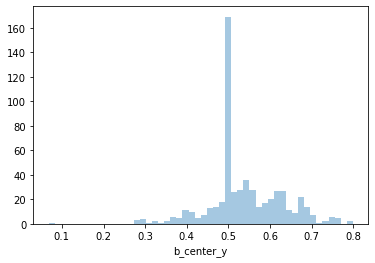

In [73]:
sns.distplot(df_labels['b_center_y'], kde=False, bins=50)

In [63]:
def centerfix(box_cen, box_size, im_size):
    if box_cen > 0.99999:
        return 0.9, \
            box_size
    elif box_cen == 0:
        return 0.5, \
            0.4
    else:
        return box_cen, \
            box_size

In [64]:
df_labels['b_center_y'], df_labels['b_height'] = zip(*df_labels.apply(lambda x: centerfix(x['b_center_y'],x['b_height'],x['img_prop'][0]), axis=1))
df_labels['b_center_x'], df_labels['b_width'] = zip(*df_labels.apply(lambda x: centerfix(x['b_center_x'],x['b_width'],x['img_prop'][1]), axis=1))

<AxesSubplot:xlabel='b_center_y'>

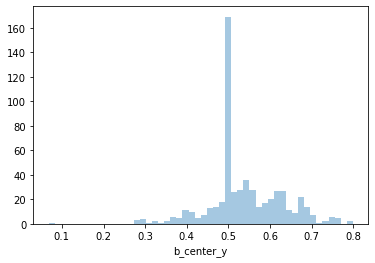

In [65]:
sns.distplot(df_labels['b_center_y'], kde=False, bins=50)

In [66]:
df_labelfile = pd.DataFrame()
df_labelfile = df_labels[['class id','b_center_x', 'b_center_y', 'b_width', 'b_height']]

In [67]:
df_labelfile[df_labelfile['b_width']>700]

,class id,b_center_x,b_center_y,b_width,b_height


In [68]:
img_path_proc = "C:\\Users\\61498\\Documents\\GitHub\\JitsPredict\\data\\processed\\images\\input\\"
annot_path_proc = "C:\\Users\\61498\\Documents\\GitHub\\JitsPredict\\data\\processed\\annotations\\input\\"

In [69]:
i=0
while i < len(df_labelfile):
    try: 
        df_labelfile.iloc[[i]].to_csv(annot_path_proc + df_labels['label_file'].iloc[i], sep=' ', index=False, header=False)
        img_file = df_labels['label_file'].iloc[i][:-4]+ ".jpg"
        shutil.copyfile(img_path + img_file, img_path_proc + img_file)
        i = i+1
    except: pass